In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
import io
from matplotlib.ticker import FuncFormatter

# maps
import folium
import branca

## `Projected Loss Ratio`

In [2]:
import plr

Projected Loss Ratio Adalah rasio yang menjadi indikator untuk menentukan laba atau rugi nya suatu portofolio perusahaan asuransi yang menggambarkan kecukupan Dana Tabarru untuk membayar klaim yang sudah terjadi dan proyeksi klaim di masa yang akan datang 
<br>
<br>
$$
\text{PLR} = \frac{\text{Klaim Yang Sudah Terjadi} + \text{Refund }Kontribusi + \text{Penyisihan Tabarru} + \text{Penyisihan Klaim Ibnr} + \text{Penyisihan Klaim dalam Proses}}{\text{Dana Tabarru}}
$$

### `Load Data & Data Preparation`

In [3]:
# load the data

dtype = {
    'pk':str,'no_polis':str,'cabang':str,'up':float,'kontribusi':float,
    'ujroh_persen':float,'share_reas1':float,'share_reas2':float,'jenis_kejadian':str,
    'status_kejadian':str,'refund':float,'klaim':float}

date_col = ['tgl_lhr','tgl_awal','tgl_akhir','tgl_kejadian']

df = pd.read_csv(
    'data/Data_VARIO_2.csv',
    dtype=dtype,
    parse_dates=date_col, # parse_dates memberitahu pandas agar kolom tertentu diinterpretasikan sebagai tanggal/waktu
    engine='pyarrow', # Engine pyarrow biasanya lebih cepat dan efisien untuk file besar, serta mendukung fitur tambahan seperti deteksi encoding yang lebih baik.
    ) 

In [4]:
df.head(5)

,pk,no_polis,grup_rekanan,cabang,segmen_pasar,nama_produk_ojk,jenis_nasabah,jaminan,tgl_lhr,tgl_awal,...,jenis_up,kontribusi,ujroh_persen,share_reas1,share_reas2,jenis_kejadian,status_kejadian,tgl_kejadian,refund,klaim
0,'211805712058670063325826,21.0047.01.05.3.2.1.5,BANK UMUM 34,CAB. PADANG,BANK UMUM,AT TA'MIN HASANAH PLAN DIRHAM,PEMBIAYAAN PENSIUNAN,JIWA,1966-06-26,2022-01-03,...,UM,13691190.53,40.0,80.0,0.0,None,None,2037-01-31,NaN,0.0
1,'211805712058670063325828,21.0047.01.05.3.2.1.5,BANK UMUM 34,CAB. PADANG,BANK UMUM,AT TA'MIN HASANAH PLAN DIRHAM,PEMBIAYAAN PENSIUNAN,JIWA,1966-06-26,2022-01-03,...,UM,3713710.73,40.0,80.0,0.0,None,None,2037-01-31,NaN,0.0
2,'211805712058670063325917,22.0041.01.04.1.1.1.5,BANK UMUM 34,CAB. PADANG,BANK UMUM,AT TA'MIN HASANAH PLAN DINAR,PEMBIAYAAN ALIANSI GOBERTAP/IMPLAN,JIWA,1988-02-01,2022-01-03,...,UM,4672000.00,40.0,50.0,0.0,refund,disetujui,2024-12-17,1985175.0,0.0
3,'211805712058670063326051,21.0056.01.01.3.10.1.5,BANK UMUM 34,CAB. PADANG,BANK UMUM,AT TA'MIN PENSIUN,PEMBIAYAAN PENSIUNAN,JIWA,1953-03-15,2022-01-03,...,UM,2114400.00,40.0,80.0,0.0,None,None,2025-01-31,NaN,0.0
4,'211805712058670063326090,21.0047.01.05.3.2.1.5,BANK UMUM 34,CAB. PADANG,BANK UMUM,AT TA'MIN HASANAH PLAN DIRHAM,PEMBIAYAAN PENSIUNAN,JIWA,1966-07-21,2022-01-06,...,UM,9767567.97,40.0,80.0,0.0,None,None,2036-12-31,NaN,0.0


Hapus Kolom Yang Tidak Digunakan 
\
PLR akan di analisa berdasarkan tahun polis, produk, cabang, dan segmen pasar

In [5]:
df.drop(columns=['share_reas1', 'share_reas2','jenis_nasabah'], axis=1, inplace=True) #hapus kolom share,jaminan,dan jenis nasabah.

In [6]:
df.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981426 entries, 0 to 981425
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   index            981426 non-null  int64         
 1   pk               981426 non-null  object        
 2   no_polis         981426 non-null  object        
 3   grup_rekanan     981426 non-null  object        
 4   cabang           981426 non-null  object        
 5   segmen_pasar     979137 non-null  object        
 6   nama_produk_ojk  981426 non-null  object        
 7   jaminan          981426 non-null  object        
 8   tgl_lhr          981426 non-null  datetime64[ns]
 9   tgl_awal         981426 non-null  datetime64[ns]
 10  tgl_akhir        981426 non-null  datetime64[ns]
 11  up               981426 non-null  float64       
 12  jenis_up         981426 non-null  object        
 13  kontribusi       981426 non-null  float64       
 14  ujroh_persen     981

kolom ujroh_persen dan refund memiliki jlh Non-Null Count yang berbeda dengan jlh Index\
kolom tersebut akan dilakukan penggantian value null dengan 0 

In [7]:
df['ujroh_persen'] = df['ujroh_persen'].fillna(0) 
df['refund'] = df['refund'].fillna(0)
df['status_kejadian'] = df['status_kejadian'].fillna(0)
df.isnull().sum()

pk                    0
no_polis              0
grup_rekanan          0
cabang                0
segmen_pasar       2289
nama_produk_ojk       0
jaminan               0
tgl_lhr               0
tgl_awal              0
tgl_akhir             0
up                    0
jenis_up              0
kontribusi            0
ujroh_persen          0
jenis_kejadian        0
status_kejadian       0
tgl_kejadian          0
refund                0
klaim                 0
dtype: int64

Validasi Data : 
\
Untuk Tipe Data float akan di validasi tiap - tiap kolom
\
Untuk Tipe Data Object akan di cek nilai unique nya

In [8]:
df.columns

Index(['pk', 'no_polis', 'grup_rekanan', 'cabang', 'segmen_pasar',
       'nama_produk_ojk', 'jaminan', 'tgl_lhr', 'tgl_awal', 'tgl_akhir', 'up',
       'jenis_up', 'kontribusi', 'ujroh_persen', 'jenis_kejadian',
       'status_kejadian', 'tgl_kejadian', 'refund', 'klaim'],
      dtype='object')

In [9]:
col_str = ['cabang','segmen_pasar','nama_produk_ojk','jenis_up','jaminan','jenis_kejadian','status_kejadian']
col_num = ['up','kontribusi','ujroh_persen','refund','klaim']

#### `Validasi Data Non Numeric`

In [10]:
mx = max( [len(df[v].unique()) for v in col_str] ) # maximum unique value

pd.DataFrame.from_dict(
    {v:list(df[v].unique()) + ['']*(mx-len(df[v].unique())) for v in col_str} | {'ix':[v+1 for v in range(mx)]}
    ).set_index('ix')

,cabang,segmen_pasar,nama_produk_ojk,jenis_up,jaminan,jenis_kejadian,status_kejadian
ix,,,,,,,
1,CAB. PADANG,BANK UMUM,AT TA'MIN HASANAH PLAN DIRHAM,UM,JIWA,None,None
2,CAB. SURABAYA,BPR,AT TA'MIN HASANAH PLAN DINAR,UT,,refund,disetujui
3,CAB. MATARAM,KOPERASI,AT TA'MIN PENSIUN,,,ND,Final Bayar
4,CAB. BANDUNG,LAINNYA,AT TA'MIN BAITU,,,PA,0
5,CAB. CIREBON,PENJAMINAN,AT TA'MIN JOINT LIFE,,,,Ditolak
6,CAB. PEKANBARU,BPRS,AT TA'MIN MUAMALAH,,,,On Proses
7,CAB. TANGERANG-SERANG,BMT,AT TA'MIN,,,,Keuangan
8,CAB. SEMARANG,BPD,,,,,
9,CAB. BOGOR,None,,,,,


dari tabel diatas bisa dilihat :
* di kolom segmen pasar Cabang DKI terdapat 2 nama
* di kolom `nama_produk_ojk` sudah benar
* di kolom `jenis_up` sudah benar
* di kolom `jaminan` sudah benar
* di kolom `jenis kejadian` sudah benar
* di kolom `status kejadian` terdapat beragam status dan terdapat pengulangan
<br>
<br>
<div stye='align-left'>maka akan dilakukan tindakan berikut :</div>

* Pengelompokan segmen pasar diubah menjadi Bank Umum, BPD, Koperasi, BPR/S, Penajaminan, Non Pembiayaan
* status kejadian dibuat menjadi status kondisi bayar, proses, dan tolak

Update Data Hasil Validasi

In [11]:
dict_kel_sp = {
    'BPR':'BPR/S','BPRS':'BPR/S','BMT':'KOPERASI','ASURANSI MIKRO':'NON PEMBIAYAAN',
    'JAMAAH HAJI':'NON PEMBIAYAAN','PEKERJA/ANGGOTA ORGANISASI':'NON PEMBIAYAAN',
    'SISWA / MAHASISWA':'NON PEMBIAYAAN','ASURANSI KUMPULAN UMUM':'NON PEMBIAYAAN',
    'PENUMPANG / TRAVEL':'NON PEMBIAYAAN','JAMAAH HAJI / UMROH':'NON PEMBIAYAAN',
    'WISATAWAN/OUTBOUND':'NON PEMBIAYAAN','PERUSAHAAN ( PT/CV )':'NON PEMBIAYAAN',
    'PEGAWAI':'NON PEMBIAYAAN'}


dict_status = {
       'None':None,'disetujui':'Final Bayar', 'BAYAR':'Final Bayar',
       'SETUJUI':'Final Bayar', 'Keuangan':'Final Bayar', 'Batal Klaim':None,
       '0':None,'DOKUMEN KURANG':'On Proses', 'PROSES':'On Proses'}

In [12]:
# penyeragaman penamaan cabang
df['cabang'] = df['cabang'].replace(
    'CAB. DKI 1','CAB. DKI JAKARTA',
    # inplace=True
    )

# penyederhanaan segmen pasar
df['segmen_pasar'] = df['segmen_pasar'].replace(
    dict_kel_sp,
    # inplace=True
    ).fillna('LAINNYA')

# penyeragaman status kejadian
df['status_kejadian'] = df['status_kejadian'].replace(
    dict_status,
    # inplace=True
    )

In [13]:
df['status_kejadian'].unique()

array([None, 'Final Bayar', 'Ditolak', 'On Proses'], dtype=object)

#### `Validasi Data Numeric`

In [14]:
df[['up','kontribusi','ujroh_persen','refund','klaim']].describe()

,up,kontribusi,ujroh_persen,refund,klaim
count,9.814260e+05,9.814260e+05,981426.000000,9.814260e+05,9.814260e+05
mean,1.243934e+08,3.397292e+06,38.608386,1.235296e+05,6.236291e+05
std,1.874553e+08,7.671030e+06,3.709315,1.261580e+06,1.317429e+07
min,3.860000e+00,0.000000e+00,0.000000,-8.410496e+05,0.000000e+00
25%,2.000000e+07,1.292500e+05,40.000000,0.000000e+00,0.000000e+00
50%,5.500000e+07,5.739000e+05,40.000000,0.000000e+00,0.000000e+00
75%,1.500000e+08,2.660900e+06,40.000000,0.000000e+00,0.000000e+00
max,1.000000e+10,2.191946e+08,50.000000,1.360510e+08,1.759585e+09


dari tabel diatas bisa maka akan dilakukan tindak lanjut sebagai berikut :
* di kolom kontribusi yang masih bernilai 0, maka akan diisi dengan nilai rata-rata
* di kolom ujroh yang bernilai 0 akan diisi dengan nilai rata-rata
* di kolom nilai refund yang bernilai negatif akan diubah menjadi sebesar maksimum nilai tabarru yang belum dijalani

jelaskan range up,kontribusi, dan ujrah yang akan dihitung:

<br>*up < 500_000 dikeluarkan
<br>*kontribusi < 25 rb dibuat jadi 25 rb.
<br>*ujrah nol

In [15]:
# keluarkan up < 500_000
df = df.loc[df['up']>500_000].copy()

# ganti nilai 0 dengan rata-rata
df.loc[df['kontribusi']<=0,'kontribusi'] = df['kontribusi'].mean()

# ganti nilai 0-25_000 dengan 25.000
df.loc[df['kontribusi']<25_000,'kontribusi']= 25_000

# ganti nilai 0 dengan rata-rata
df.loc[df['ujroh_persen']<=0,'ujroh_persen'] = df['ujroh_persen'].mean()

# ganti nilai minus dengan minimum antara absolute refund dan nilai tabarru
df['refund'] = np.where(
    df['refund']>=0,
    df['refund'], 
    np.minimum(
        df['refund'].abs(),
        df['kontribusi']*(1-df['ujroh_persen']/100)
        )
    )

#### `Validasi tipe Data Tanggal`

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 981294 entries, 0 to 981425
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   pk               981294 non-null  object        
 1   no_polis         981294 non-null  object        
 2   grup_rekanan     981294 non-null  object        
 3   cabang           981294 non-null  object        
 4   segmen_pasar     981294 non-null  object        
 5   nama_produk_ojk  981294 non-null  object        
 6   jaminan          981294 non-null  object        
 7   tgl_lhr          981294 non-null  datetime64[ns]
 8   tgl_awal         981294 non-null  datetime64[ns]
 9   tgl_akhir        981294 non-null  datetime64[ns]
 10  up               981294 non-null  float64       
 11  jenis_up         981294 non-null  object        
 12  kontribusi       981294 non-null  float64       
 13  ujroh_persen     981294 non-null  float64       
 14  jenis_kejadian   981294 n

In [17]:
# tgl refund dan tgl klaim > tgl akhir
(df['tgl_akhir']<df['tgl_kejadian']).sum()

99

In [18]:
# drop data dgn tgl refund dan tgl klaim > tgl akhir
df = df.loc[df['tgl_akhir']>=df['tgl_kejadian']].copy()

In [19]:
# data dgn tgl refund dan tgl klaim < tgl awal
(df['tgl_awal']>df['tgl_kejadian']).sum()

23

In [20]:
# drop data dgn tgl refund dan tgl klaim < tgl awal
df = df.loc[df['tgl_awal']<df['tgl_kejadian']]

In [21]:
(df['tgl_akhir']<df['tgl_awal']).sum(),(df['tgl_awal']>df['tgl_kejadian']).sum()

(0, 0)

#### `Penambahan Feature yang dibutuhkan pada dataframe`

disamping tipe data dan non-null value dari data, akan dilakukan penambahan kolom-kolom yang dibutuhkan untuk perhitungan selanjutnya\
seperti tanggal valuasi, status peserta, tabarru, usia, masa asuransi, usia jatuh tempo (x+n) dan bulan valuasi (mv), klaim dibayar, klaim dalam proses (klaim os)

In [22]:
# Membuat Kolom Status
df['tgl_val'] = pd.to_datetime('2024-12-31')

# Fungsi status
def status2(akhir:pd.Series, val:pd.Series, status:pd.Series) -> pd.Series:
    res = np.where(
        status == 'refund', 'refund',
        np.where(
            status != 'None', 'Klaim',
            np.where(
                akhir < val, 'Jatuh Tempo',
                'Inforce')))
    
    return pd.Series(res, index=akhir.index)


In [23]:
df['status_peserta'] = status2(df['tgl_akhir'],df['tgl_val'],df['jenis_kejadian'])

In [24]:
# tambahkan kolom tabarru, usiam masa asuransi dlm bulan, usia jatuh tempo dan bulan valuasi


df['tabarru'] = df['kontribusi'] * (1 - df['ujroh_persen']/100)
df['ujroh'] = df['kontribusi'] * (df['ujroh_persen']/100)

df['usia'] = np.round((df['tgl_awal'] - df['tgl_lhr']).dt.days / 365.25,0)
df['usia'] = df['usia'].fillna(0).astype(int)

df['masa_asuransi_bulan'] = np.round((df['tgl_akhir'] - df['tgl_awal']).dt.days / 365.25 * 12,0)
df['masa_asuransi_bulan'] = df['masa_asuransi_bulan'].fillna(0).astype(int)
df['masa_asuransi_bulan'] = df['masa_asuransi_bulan'].replace(0, 1)

df['masa_asuransi_tahun'] = np.round(df['masa_asuransi_bulan']/12,0)

#usia jatuh tempo
df['xn'] = np.round((df['tgl_akhir'] - df['tgl_lhr']).dt.days / 365.25,0)
df['xn'] = df['xn'].fillna(0).astype(int)

# mv
df['mv'] = np.where(df['status_peserta']=='Inforce',np.round((df['tgl_val'] - df['tgl_awal']).dt.days / 365.25 * 12,0),0)

In [25]:
df[['usia','masa_asuransi_bulan']].describe()

,usia,masa_asuransi_bulan
count,981134.000000,981134.000000
mean,41.106878,67.087702
std,10.326673,56.630012
min,1.000000,1.000000
25%,33.000000,24.000000
50%,40.000000,48.000000
75%,48.000000,97.000000
max,116.000000,361.000000


In [26]:
#Klaim Dibayar
# df['klaim_dibayar'] = df.apply(lambda row: row['klaim'] if row['status_kejadian'] == 'Final Bayar' else 0, axis=1)
df['klaim_dibayar'] = np.where(df['status_kejadian'] == 'Final Bayar', df['klaim'],0)

In [27]:
#Klaim os
# df['klaim_os'] = df.apply(lambda row: row['klaim'] if row['status_kejadian'] == 'On Proses' else 0, axis=1)
df['klaim_os'] = np.where(df['status_kejadian'] == 'On Proses', df['klaim'],0)

### `Gambaran Umum Portofolio Peserta`

In [28]:
df['pst']=1
df['tahun'] = df['tgl_awal'].dt.year

In [29]:
df.loc[df['tahun']==2024].shape

(299918, 32)

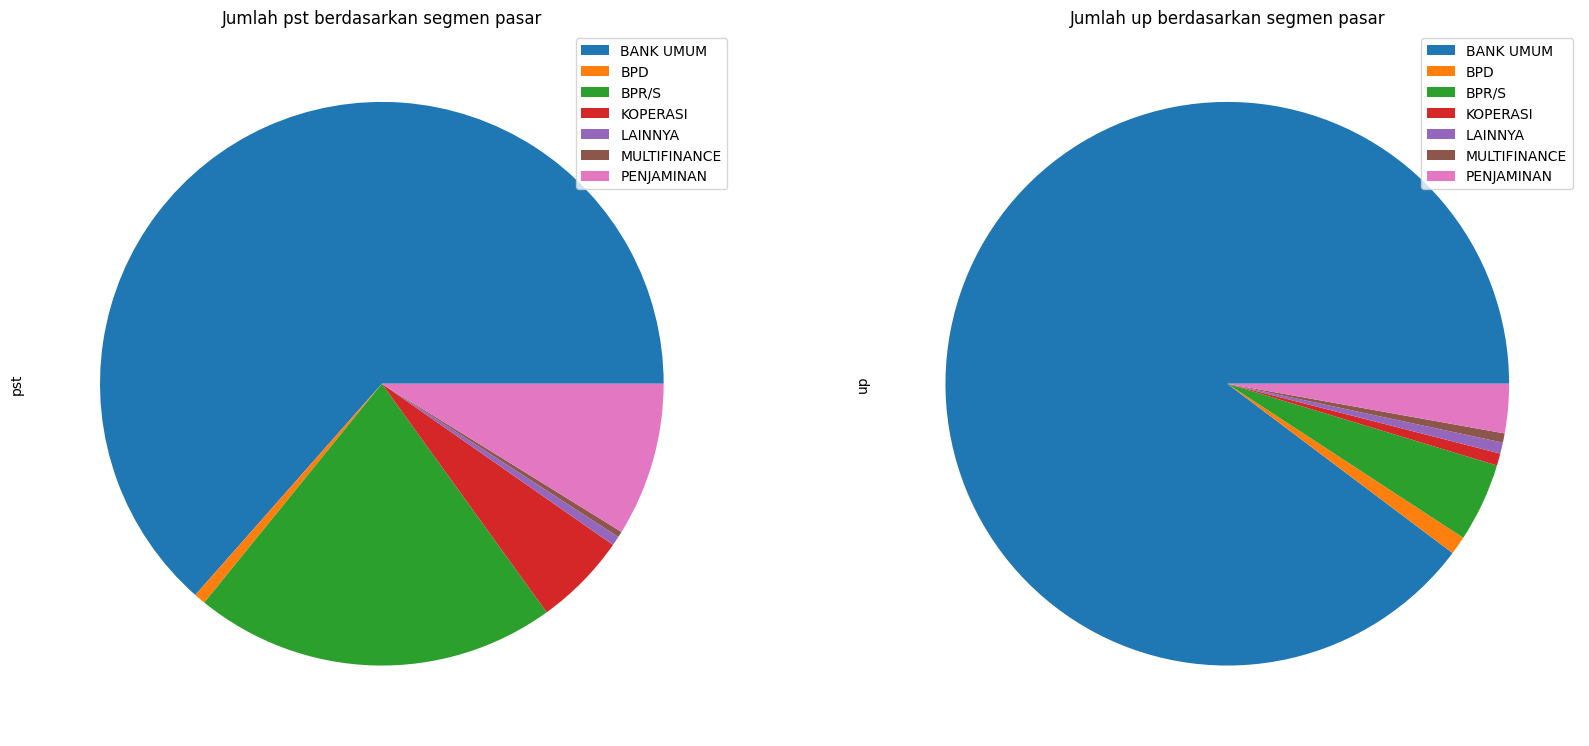

In [30]:
cols = ['pst','up']
fig, axes = plt.subplots(1, len(cols), figsize=(20,10), squeeze=False)

for i, col in enumerate(cols):
        df[['segmen_pasar',col]].groupby(['segmen_pasar']).sum().plot(
            kind='pie',
            y=col,
            ax=axes[0,i],
            title=f'Jumlah {col} berdasarkan segmen pasar',
            # autopct="%.1f%%",
            labels=None
            )

plt.show()

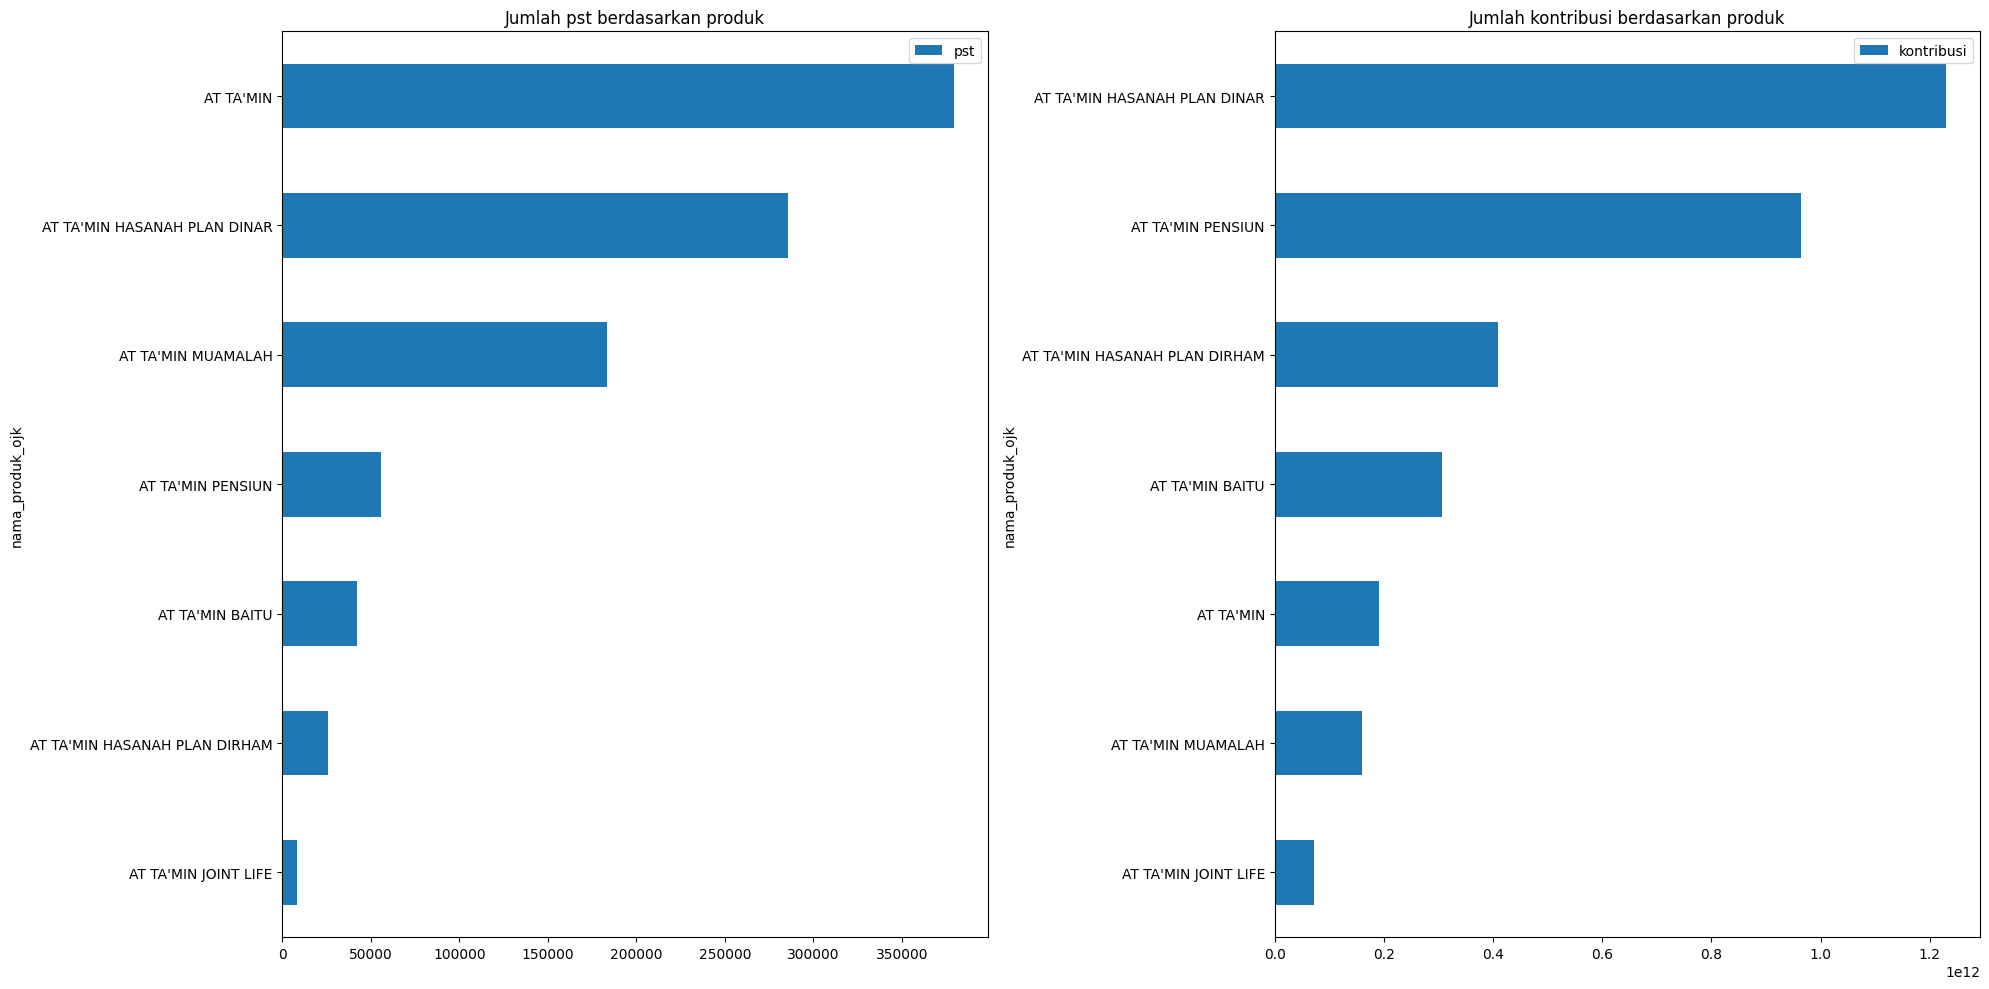

In [31]:
cols = ['pst','kontribusi']
fig, axes = plt.subplots(1, len(cols), figsize=(20,10), squeeze=False)

for i, col in enumerate(cols):
        df[['nama_produk_ojk',col]].groupby(['nama_produk_ojk']).sum().sort_values(col).plot(
            kind='barh',
            y=col,
            ax=axes[0,i],
            title=f'Jumlah {col} berdasarkan produk',
            # autopct="%.1f%%",
            # labels=None
            )
plt.tight_layout()
plt.show()

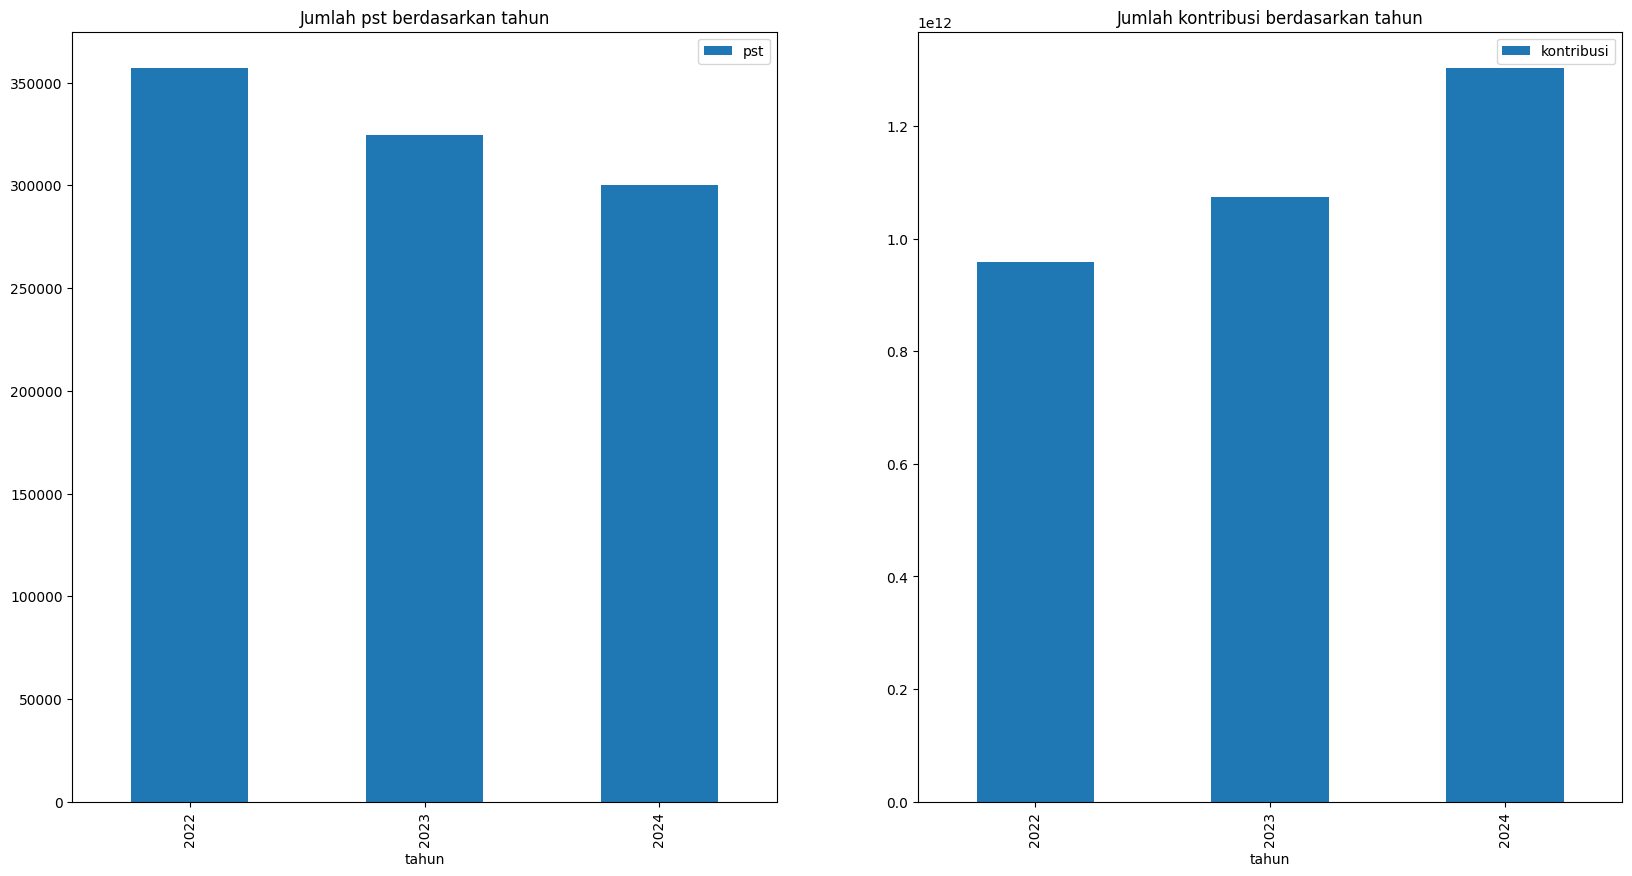

In [32]:
cols = ['pst','kontribusi']
fig, axes = plt.subplots(1, len(cols), figsize=(20,10), squeeze=False)

for i, col in enumerate(cols):
        df[['tahun',col]].groupby(['tahun']).sum().plot(
            kind='bar',
            y=col,
            ax=axes[0,i],
            title=f'Jumlah {col} berdasarkan tahun',
            )

plt.show()

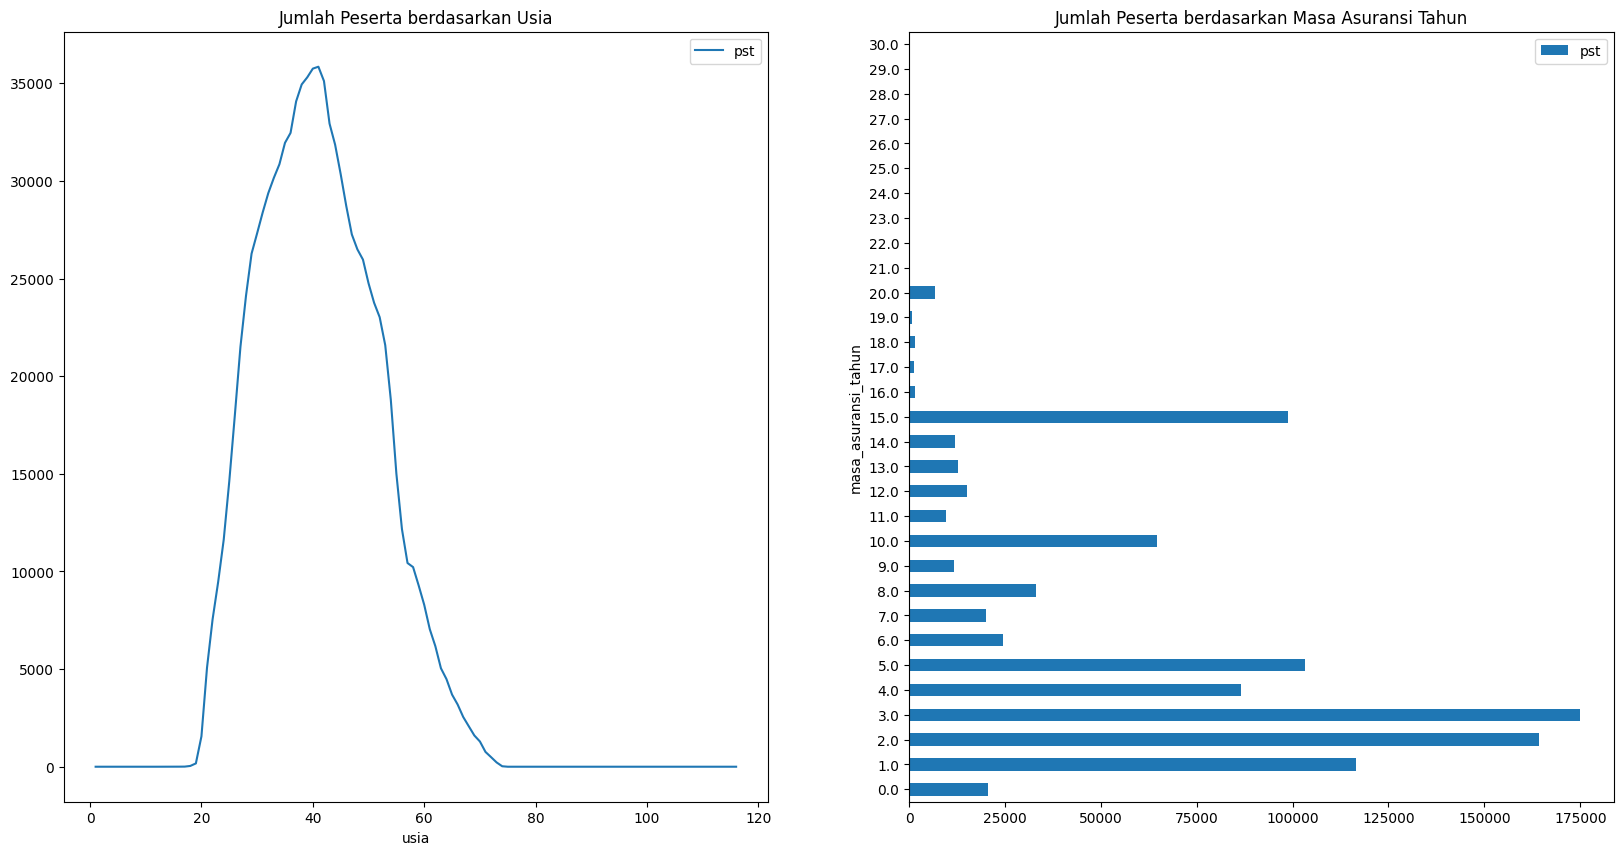

In [33]:
cols = ['usia','masa_asuransi_tahun']
tipe = ['line','barh']

fig, axes = plt.subplots(1, len(cols), figsize=(20,10), squeeze=False)

for i, col in enumerate(cols):
    df.loc[:,[col,'pst']].groupby(col).sum().plot(
        kind=tipe[i],  # type: ignore[arg-type]
        ax=axes[0,i],
        title=f'Jumlah Peserta berdasarkan {(" ".join(col.split("_")).title())}',
        )

plt.show()

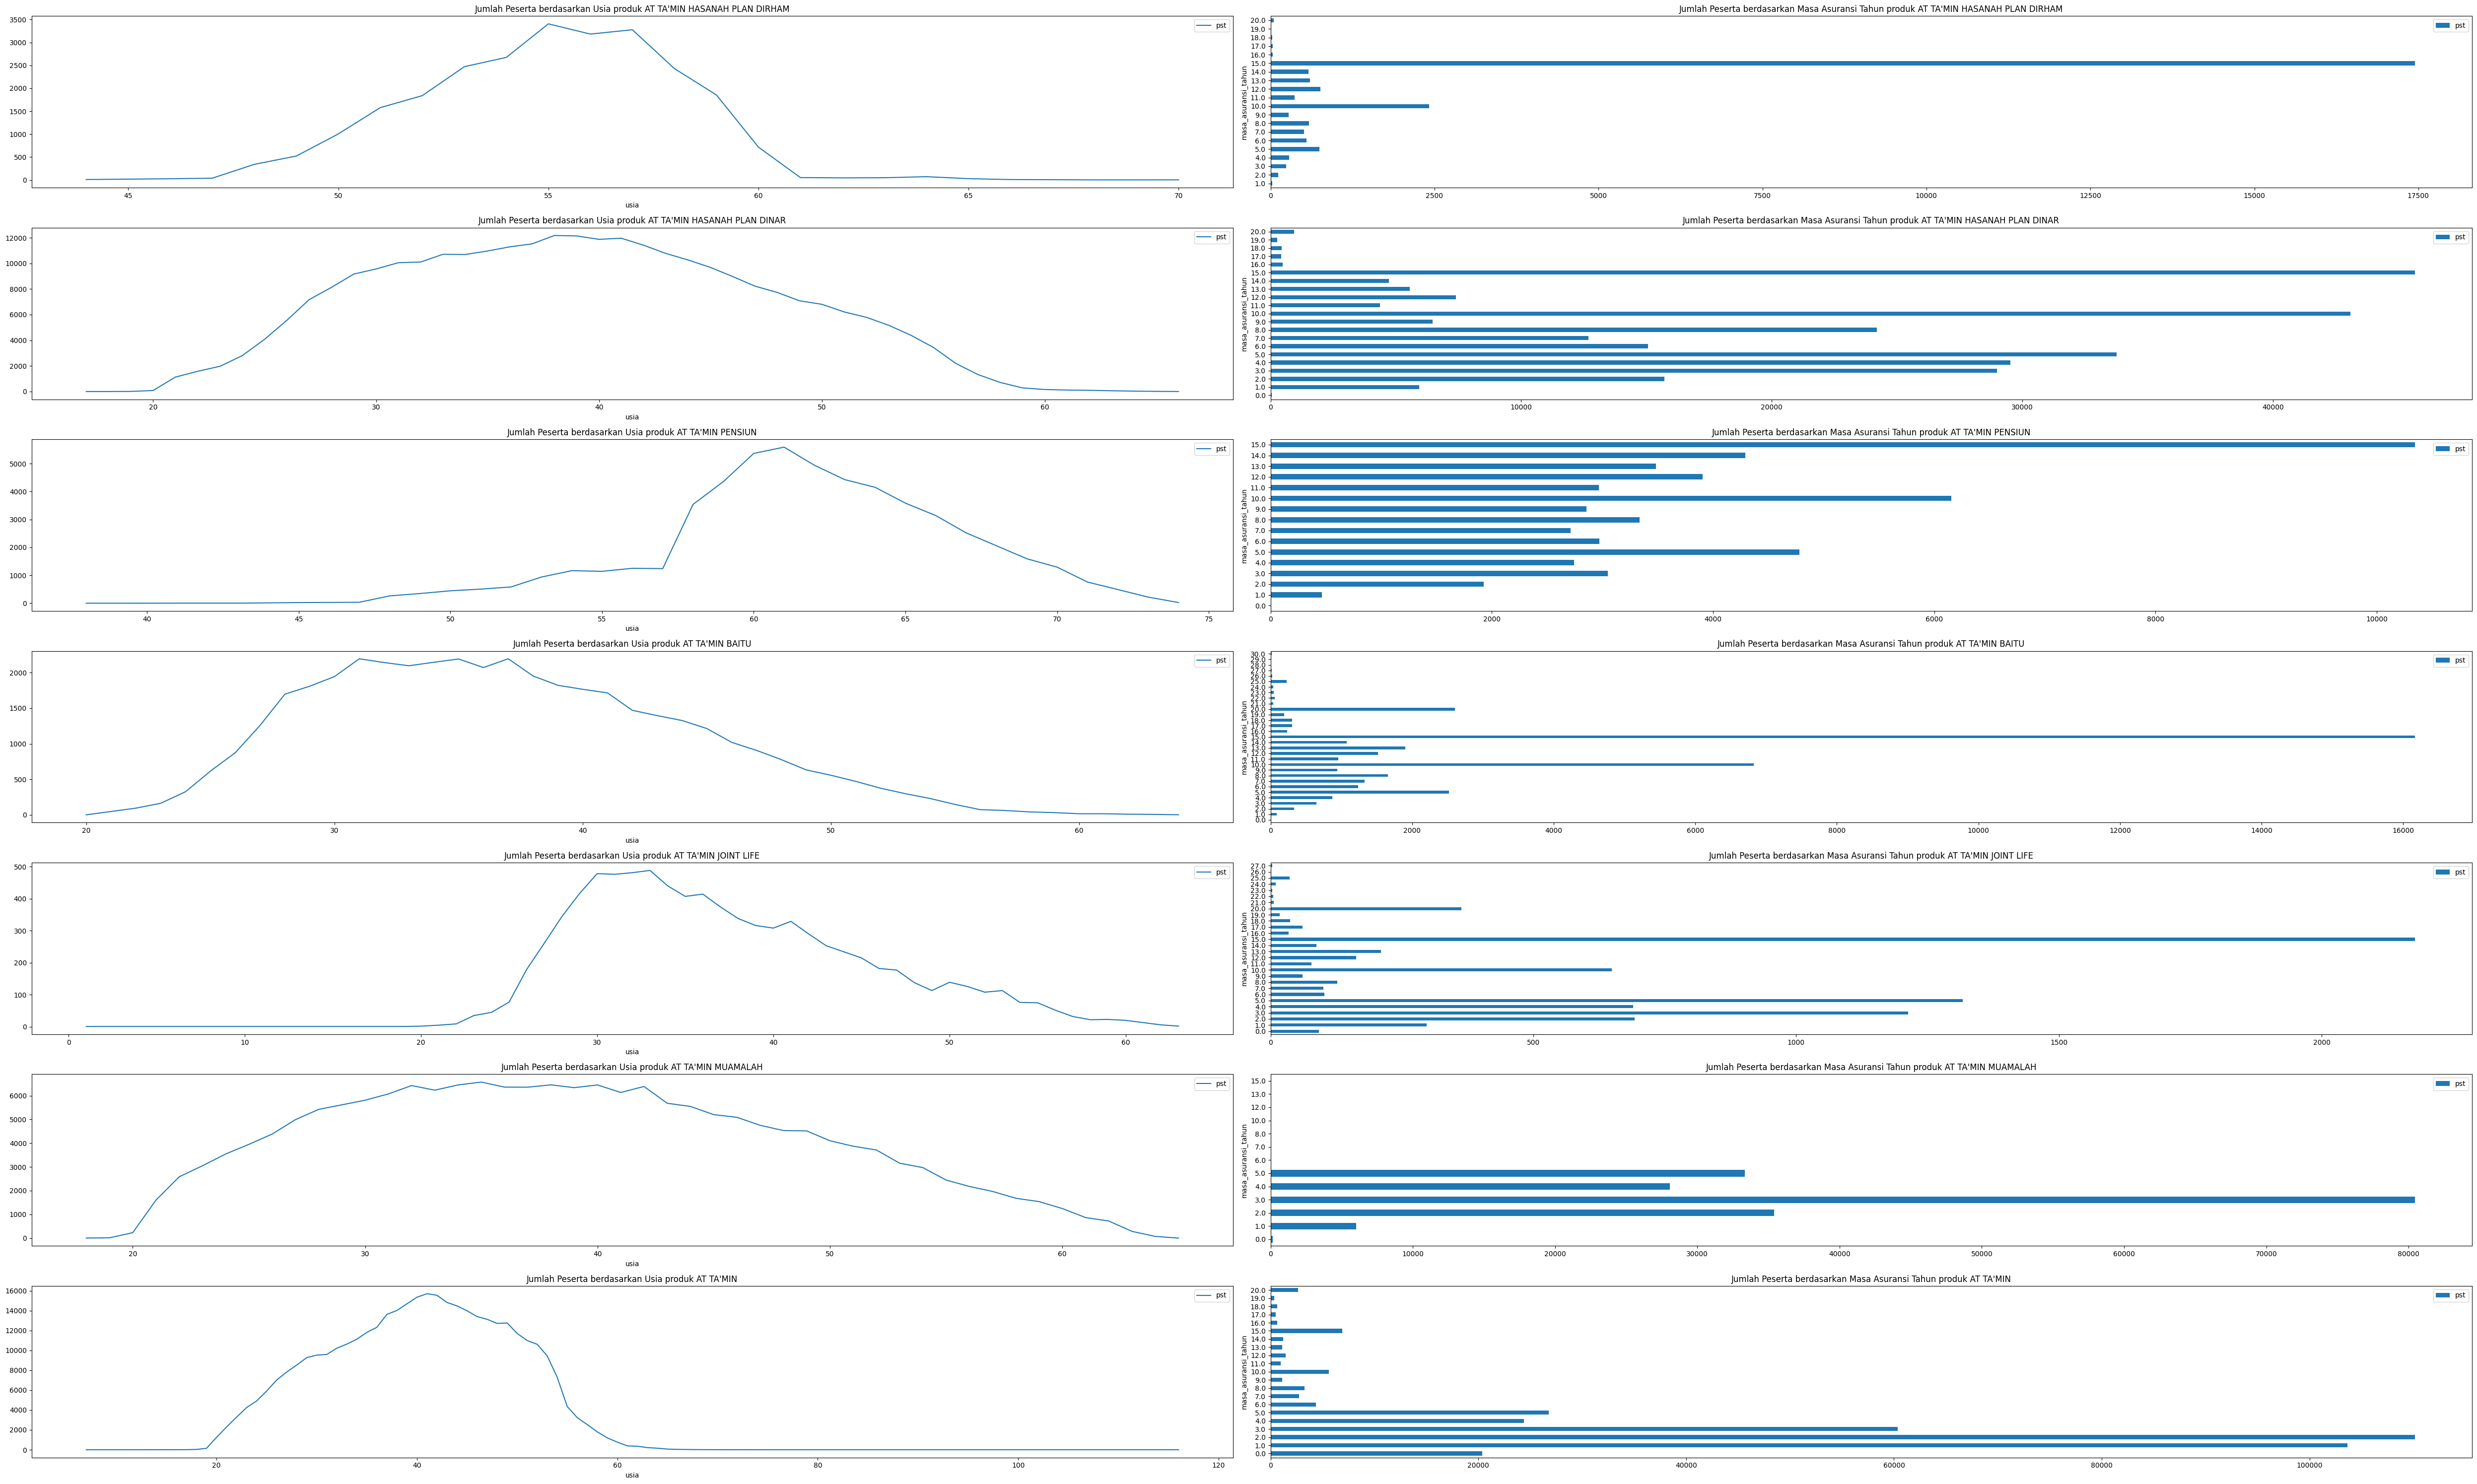

In [34]:
cols = ['usia','masa_asuransi_tahun']
tipe = ['line','barh']

produk = df['nama_produk_ojk'].unique()

fig, axes = plt.subplots(len(produk), len(cols), figsize=(50,30), squeeze=False)

for i, col in enumerate(cols):
    for j,col2 in enumerate(produk):
        df.loc[df['nama_produk_ojk']==col2,[col,'pst']].groupby(col).sum().plot(
            kind=tipe[i],  # type: ignore[arg-type]
            ax=axes[j,i],
            title=f'Jumlah Peserta berdasarkan {(" ".join(col.split("_")).title())} produk {col2}',
            )

plt.tight_layout()
plt.savefig('plot image.png')
plt.show()

### `Rasio Klaim (Claim Ratio/Loss Ratio)`

Rasio Klaim adalah perbandingan dari nilai klaim dan nilai tabarru bla bla bla\
adapun formula yang digunakan untuk menghitung tasio klaim adalah sebagai berikut:
$$
Rasio\ Klaim = \frac{Total\ Klaim\ +\ Total\ Refund}{Total\ Tabarru}
$$

adapun penerapan formula diatas pada kode python adalah sbb:
```python
def claim_ratio(df:pd.DataFrame, simple:bool=False) -> pd.Series|pd.DataFrame:
    df['rasio_klaim'] = (df['klaim'] + df['refund']) / df['tabarru']
    df['rasio_klaim'] = df['rasio_klaim'].fillna(0)
    return df[['rasio_klaim']].sort_values('rasio_klaim', ascending=False) if simple else df.sort_values('rasio_klaim', ascending=False)
```

In [36]:
plr.claim_ratio(
        plr.grouper(df=df, groupby_col='nama_produk_ojk'),simple=True
        )

,rasio_klaim
nama_produk_ojk,
AT TA'MIN MUAMALAH,0.634959
AT TA'MIN,0.439075
AT TA'MIN HASANAH PLAN DIRHAM,0.405857
AT TA'MIN PENSIUN,0.376307
AT TA'MIN HASANAH PLAN DINAR,0.288504
AT TA'MIN BAITU,0.175254
AT TA'MIN JOINT LIFE,0.073186


### `Penyisihan/Cadangan Tabarru`

<div style="text-align: justify"> Perhitungan penyisihan (cadangan) diperlukan untuk menghitung PLR, nilai penyisihan didapatkan dari nilai kini atas manfaat kematian yang diproyeksikan akan terjadi di masa depan. Nilai ini dihitung dari peserta-peserta yang masih aktif di saat perhitungan dilakukan dengan mengelompokkan antara peserta risiko jangka pendek dengan masa asuransi s.d 1 tahun (s.d 12 bulan) dan juga peserta yang memiliki mas asuransi lebih besar dari 1 tahun (>12 bulan). Kelompok peserta dengan masa asuransi pendek kita namakan kelompok peserta <b>KYBMP (Kontribusi Yang Belum Merupakan Pendapatan)</b>. Kelompok peserta dengan masa asuransi pendek kita namakan kelompok peserta <b>Penyisihan Risiko</b>.</div>

Adapun kode python dari penerapan formula yang akan digunakan ditempatkan pada module terpisah di file `plr.py` untuk mempermudah koreksi apabila terjadi error ketika perhitungan dijalankan.

#### `KYBMP`

* formula yang digunakan untuk menghitung penyisihan kelompok peserta <b>KYBMP</b> adalah sebagai berikut :
$$
KYBMP\ =\ \frac{a}{b} \times Tabarru
$$

Keterangan :
<br>
&nbsp;&nbsp;&nbsp;&nbsp;$a : \text{Tanggal Akhir} - \text{Tanggal Valuasi}$\
&nbsp;&nbsp;&nbsp;&nbsp;$b : \text{Tanggal Akhir} - \text{Tanggal Masuk}$\
&nbsp;&nbsp;&nbsp;&nbsp;$Tabarru : \text{Kontribusi} - \text{Ujrah}$

untuk penerapan formulanya dalam python adalah sebagai berikut
```python
def kybmp(df:pd.DataFrame, simple:bool=False) -> pd.Series|pd.DataFrame:
    df['Penyisihan'] = (df['tgl_akhir'] - df['tgl_val']).days / (df['tgl_akhir'] - df['tgl_awal']).days * df['tabarru']    
    return df['Penyisihan'] if simple else df
```

In [38]:
df.loc[(df['masa_asuransi_bulan']<=12) & (df['tgl_akhir']>df['tgl_val'])].shape

(18127, 32)

peserta KYBMP pada periode perhitungan yang masih aktif adalah 18,131 peserta

#### `Penyisihan Risiko`

* formula yang digunakan untuk menghitung penyisihan kelompok peserta <b>Penyisihan Risiko</b> adalah sebagai berikut :
$$
tV = pv\,\text{Cash out Tabarru}
$$\

Keterangan :<br>
&nbsp;&nbsp;&nbsp;&nbsp;$tV : Penyisihan Tabarru$\
&nbsp;&nbsp;&nbsp;&nbsp;$pv\,\text{Cash out Tabarru} : \text{nilai kini dari estimasi klaim masa depan}$

Dimana :
$$
pv\,\text{Cash out Tabarru} = \sum_{k=0}^{n-1} v^{k+1} \, {}_{k}P_{x}^{(T)} \, q_{x+k}^{(d)} \, UP_{k+1}
$$

Keterangan :\
&nbsp;&nbsp;&nbsp;&nbsp;$v^{k+1} : \text{Nilai kini sepanjang k}$\
&nbsp;&nbsp;&nbsp;&nbsp;${}_{k}P_{x}^{(T)} : \text{Peluang hidup total x sepanjang k bulan}$\
&nbsp;&nbsp;&nbsp;&nbsp;$\, q_{x+k}^{(d)} : \text{Peluang meninggal pada usia } x+k $\
&nbsp;&nbsp;&nbsp;&nbsp;$\, q_{x+k}^{(w)} : \text{Peluang withdrawal pada usia } x+k$\
&nbsp;&nbsp;&nbsp;&nbsp;$\, UP_{k+1} : \text{Uang Pertanggungan pada saat }k+1$
<br>
<br>
untuk penerapan kodingan pythonnya adalah sebagai berikut:
```python
def penyisihan_tabarru(x:int, m:int, up:float, mv:int, qxList:list,iAktu:float=0.04)->float:

        qx = np.array(qxList)  # list with float value

        lTahun = np.zeros(m,dtype=np.int64)
        lBulan = np.zeros(m,dtype=np.int64)
        for i in nb.prange(m):
            lTahun[i] = ceil((i+1)/12) # list tahun
        
        for i in nb.prange(m):
            lBulan[i] = i+1 # list bulan

        lUsia = np.zeros(m,dtype=np.int64)  # list usia
        llx = np.zeros(m)  # list Lx
        ldx = np.zeros(m)  # list dx
        lrx = np.zeros(m)  # list rx

        deathOutgo = np.zeros(m)

        lup = os_up(up,m) # list sisa up

        liAktu = np.array([iAktu]*30) # Maksimum Masa asuransi s.d 30 tahun

        discRate = np.zeros(m)
        pvDeathOutgo = np.zeros(m)

        if m < 12:
            pass
        else:
            for i in nb.prange(0, m):
                lUsia[i] = (x+lTahun[i]-1)
                if i == 0:
                    llx[i] = 1
                else :
                    llx[i] = llx[i-1]-ldx[i-1]-lrx[i-1]

                ldx[i] = qx[lUsia[i]]/12 * llx[i]
                if i+1 < m:
                    lrx[i] = 0
                else:
                    lrx[i]= llx[i]-ldx[i]
                    
                deathOutgo[i] = (lup[i]*ldx[i])
                if lBulan[i] <= (mv+12) :
                    discRate[i] = ((1 + liAktu[0])**(1/12)-1)
                else :
                    discRate[i] = (((1+liAktu[ceil((lBulan[i]-int(mv))/12)-1])**(1/12))-1)

            for i in nb.prange(0, m):
                if i == 0 :
                    pvDeathOutgo[i] = ((deathOutgo[m-i-1])/(1+discRate[m-i-1]))
                else:
                    pvDeathOutgo[i] = ((deathOutgo[m-i-1]+pvDeathOutgo[i-1])/(1+discRate[m-i-1]))

            pvDeathOutgo_ret = np.zeros_like(pvDeathOutgo)
            for i in nb.prange(len(pvDeathOutgo)):
                pvDeathOutgo_ret[i] = pvDeathOutgo[-(i+1)]

        try:
            if mv < 0:
                return 1
            else:
                res = pvDeathOutgo[int(mv)-1]/llx[int(mv)-1]
                return res
        except:
            return np.nan
```

untuk menyederhanakan perhitungan, maka penurunan UP dibuat menurun sederhana
$$
UP_{k+1} =\ \frac{a}{b} \times UP
$$

Keterangan :
<br>
&nbsp;&nbsp;&nbsp;&nbsp;$a : \text{Masa Asuransi (bulan)} - \text{Bulan Valuasi}$\
&nbsp;&nbsp;&nbsp;&nbsp;$b : \text{Masa Asuransu (bulan)}$\
&nbsp;&nbsp;&nbsp;&nbsp;$UP : \text{Uang Pertanggungan}$
<br>
<br>
Untuk penerapan pada kodingan python adalah sebagai berikut :
```python
def os_up(up:float,m:int)->np.ndarray:
    res = np.zeros(m)
    for i in nb.prange(m):
        res[i] = ( (m-i)/m ) * up

    return res
```

In [39]:
filter_inf = df['tgl_akhir']>df['tgl_val']
filter_kybmp = df['masa_asuransi_bulan']<=12
inforce_risk = df.loc[filter_inf & ~filter_kybmp].copy()
inforce_kybmp = df.loc[filter_inf & filter_kybmp].copy()

##### `Tabel Mortalita`

In [40]:
res = requests.get(
    'https://mort.soa.org/Export.aspx?Type=csv&TableIdentity=50013',
    # params={'ASP.NET_SessionId':'iWasHereB3foreYouKn0wMe'}
    ) #'xfnhnmofadhrnvb4ui4lro2i'

In [41]:
tmi_99 = pd.read_csv(io.StringIO(res.text),skiprows=22)['1'].to_list()
tmi_99 = [min(v * 1.5,1.0) for v in tmi_99]

In [42]:
inforce_risk['qx'] = [tmi_99 for _ in range(inforce_risk.shape[0])]

In [43]:
pd.options.display.float_format = '{:,.2f}'.format

#### `Penyisihan Tabarru`

In [44]:
# penyisihan risiko

col_used = ['usia','masa_asuransi_bulan','up','mv','qx']
inforce_risk['penyisihan_tabarru'] = plr.pt_process(inforce_risk.loc[:,col_used],plr.pt_pandas)

In [45]:
# penyisihan kybmp
inforce_kybmp['penyisihan_tabarru'] = plr.kybmp(inforce_kybmp,simple=True)

In [46]:
inforce = pd.concat([inforce_risk,inforce_kybmp])
df = df.set_index('pk').join(inforce.set_index('pk')[['penyisihan_tabarru']],how='left')

In [47]:
df['penyisihan_tabarru'] = df['penyisihan_tabarru'].fillna(0)

### `Penyisihan Klaim Dalam Proses`

In [48]:
df['penyisihan_klaim_proses'] = df['klaim_os'] #.fillna(0)

### `Penyisihan Klaim IBNR`

In [49]:
ibnr_all = 16078891456.228
penyisihan_kontribusi = 2206353701663.83
penyisihan_kybmp = 883100786.27328

ibnr_factor= ibnr_all / (penyisihan_kontribusi + penyisihan_kybmp)

df['penyisihan_klaim_ibnr'] = ibnr_factor * df['penyisihan_tabarru']

df.head()

,no_polis,grup_rekanan,cabang,segmen_pasar,nama_produk_ojk,jaminan,tgl_lhr,tgl_awal,tgl_akhir,up,...,masa_asuransi_tahun,xn,mv,klaim_dibayar,klaim_os,pst,tahun,penyisihan_tabarru,penyisihan_klaim_proses,penyisihan_klaim_ibnr
pk,,,,,,,,,,,,,,,,,,,,,
'211805712058670063325826,21.0047.01.05.3.2.1.5,BANK UMUM 34,CAB. PADANG,BANK UMUM,AT TA'MIN HASANAH PLAN DIRHAM,JIWA,1966-06-26,2022-01-03,2037-01-31,"264,819,932.95",...,15.00,71,36.00,0.00,0.00,1,2022,"28,652,969.78",0.00,"208,726.13"
'211805712058670063325828,21.0047.01.05.3.2.1.5,BANK UMUM 34,CAB. PADANG,BANK UMUM,AT TA'MIN HASANAH PLAN DIRHAM,JIWA,1966-06-26,2022-01-03,2037-01-31,"76,713,710.74",...,15.00,71,36.00,0.00,0.00,1,2022,"8,300,265.06",0.00,"60,464.31"
'211805712058670063325917,22.0041.01.04.1.1.1.5,BANK UMUM 34,CAB. PADANG,BANK UMUM,AT TA'MIN HASANAH PLAN DINAR,JIWA,1988-02-01,2022-01-03,2032-01-31,"200,000,000.00",...,10.00,44,0.00,0.00,0.00,1,2022,629.67,0.00,4.59
'211805712058670063326051,21.0056.01.01.3.10.1.5,BANK UMUM 34,CAB. PADANG,BANK UMUM,AT TA'MIN PENSIUN,JIWA,1953-03-15,2022-01-03,2025-01-31,"60,000,000.00",...,3.00,72,36.00,0.00,0.00,1,2022,"26,468.09",0.00,192.81
'211805712058670063326090,21.0047.01.05.3.2.1.5,BANK UMUM 34,CAB. PADANG,BANK UMUM,AT TA'MIN HASANAH PLAN DIRHAM,JIWA,1966-07-21,2022-01-06,2037-01-31,"201,767,567.97",...,15.00,71,36.00,0.00,0.00,1,2022,"20,030,876.20",0.00,"145,917.41"


### `PLR (Projected Loss Ratio)`

In [ ]:
ax = plr.claim_ratio(
    plr.grouper(
        df=df,
        groupby_col=['nama_produk_ojk'],
        added_col=['penyisihan_tabarru','penyisihan_klaim_ibnr','penyisihan_klaim_proses']),
    simple=False,
    projected=True
)['rasio_klaim'].sort_values().plot(kind='barh',figsize=(15,8),grid=True)

ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

#### `Prod per Tahun`

In [ ]:
df['tahun'] = df['tgl_awal'].dt.year

In [ ]:
prod_list = list(plr.claim_ratio(
    plr.grouper(
        df=df,groupby_col=['nama_produk_ojk'],
        added_col=['penyisihan_tabarru','penyisihan_klaim_ibnr','penyisihan_klaim_proses']),
    simple=False,
    projected=True
)['rasio_klaim'].head(4).index)

In [ ]:
products = prod_list

fig, axes = plt.subplots(1, len(products), figsize=(35,15), squeeze=False)

for i, product in enumerate(products):
    # filter_1 = df['tahun']==product
    filter_2 = df['nama_produk_ojk']==product
    piv = plr.claim_ratio(
        plr.grouper(
        df=df.loc[
            # filter_1 & 
            filter_2],
        groupby_col=['tahun'],
        added_col=['penyisihan_klaim_ibnr','penyisihan_tabarru','penyisihan_klaim_proses']
        ),projected=True,simple=False
        )[['rasio_klaim']].sort_values('rasio_klaim',ascending=False)
    ax = piv.head(4)['rasio_klaim'].plot(
            kind='bar',
            ax=axes[0,i],
            grid=True,
            title=f'Projected Loss Ratio {product.title()} per tahun',
            )
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

plt.show()

#### `prod per Segment`

In [ ]:
products = prod_list

fig, axes = plt.subplots(1, 4, figsize=(30,10), squeeze=False)

for i, product in enumerate(products):
    # row_n = int(np.floor_divide(i,4))
    # col_n = i % 4
    # print(row_n,col_n)
    ax = plr.claim_ratio(
        plr.grouper(
            df=df.loc[df['nama_produk_ojk']==product],
            groupby_col=['segmen_pasar'],added_col=['penyisihan_tabarru','penyisihan_klaim_ibnr','penyisihan_klaim_proses']
            ),projected=True
            ).head(5)['rasio_klaim'].sort_values().plot(
                kind='bar',
                grid=True,
                ax=axes[0, i],
                title=f'Segmen {" ".join(product.split("_")).title()}',
                # autopct="%.1f%%"
                )
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

fig.tight_layout(pad=5.0)
plt.show()

#### `By Cabang All Product`

In [ ]:
res = requests.get('https://raw.githubusercontent.com/superpikar/indonesia-geojson/refs/heads/master/indonesia-province.json')
json_indo = res.json()

In [ ]:
def get_map(df,json_indo):
    indo = gpd.GeoDataFrame.from_features(json_indo, crs="EPSG:4326").iloc[:,[0,3]]
    df['Provinsi'] = df['cabang'].apply(lambda x:plr.cab_gj[x])

    # menambahkan kolom kontribusi, tabarru, klaim, penyisihan tabarru, penyisihan klaim dan rasio klaim (PLR) ke geodataframe
    col=['Provinsi']
    prov = plr.grouper(
                df=df.loc[df['Provinsi']!='None'],
                groupby_col=col,
                added_col=['penyisihan_tabarru','penyisihan_klaim_ibnr','penyisihan_klaim_proses'])
    prov['rasio_klaim'] = plr.claim_ratio(prov,simple=True,projected=True)
    indo_merge = indo.merge(prov,left_on='Propinsi',right_on='Provinsi',how='left').fillna(0)

    df_loc = pd.DataFrame(
        {"Column": pd.json_normalize(json_indo["features"])["properties.Propinsi"]}
    ).assign(Columnnext=lambda d: d["Column"].str.len())

    # dictionary rasio klaim
    rk_dict = plr.claim_ratio(prov,simple=True,projected=True)['rasio_klaim'].to_dict() # dict rasio klaim
    rk_dict = rk_dict | {v:0 for v in (set(df_loc['Column'].values)-set(rk_dict.keys()))}

    colormap = branca.colormap.LinearColormap(  # type: ignore
        vmin=0,
        vmax=plr.claim_ratio(prov,simple=True,projected=True)['rasio_klaim'].max(),
        colors=['green','yellow','red'],
        caption="Projected Claim Ratio"
        )

    M = folium.Map([-1, 117.5],zoom_start=5)

    popup = folium.GeoJsonPopup(
        fields=["Propinsi", "kontribusi",'tabarru','ujroh','klaim','refund','penyisihan_tabarru','penyisihan_klaim_ibnr','rasio_klaim'],
        aliases=["Provinsi", "kontribusi",'tabarru','ujroh','klaim','refund','penyisihan_tabarru','penyisihan_klaim_ibnr','PLR'],
        localize=True,
        labels=True,
        style="background-color: yellow;",
    )

    tooltip = folium.GeoJsonTooltip(
        fields=["Propinsi", "kontribusi",'tabarru','ujroh','klaim','refund','penyisihan_tabarru','penyisihan_klaim_ibnr','rasio_klaim'],
        aliases=["Provinsi", "kontribusi",'tabarru','ujroh','klaim','refund','penyisihan_tabarru','penyisihan_klaim_ibnr','PLR'],
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 2px solid black;
            border-radius: 3px;
            box-shadow: 3px;
        """,
        max_width=500,
    )

    folium.GeoJson(
        # json_indo,
        indo_merge,
        zoom_on_click=True,
        style_function=lambda feature: {
            "fillColor": colormap(rk_dict[feature["properties"]["Propinsi"]]),
            "color": "black",
            "weight": 1,
            "dashArray": "1, 3",
            "fillOpacity": 0.9,
        },
        popup=popup,
        tooltip=tooltip
        ).add_to(M)
    colormap.add_to(M)
    return M

In [ ]:
M = get_map(df.loc[df['nama_produk_ojk']=="AT TA'MIN"].copy(),json_indo)
M

Ketika di tampilkan pada peta, terlihat bahwa dari tiap pulau setidaknya memiliki satu provinsi dengan projected klaim rasio yang tinggi, dan projected klaim rasio tertinggi terdapat di daerah kalimantan